## Load/import packages

In [1]:
import ffmpeg
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skvideo
skvideo.setFFmpegPath(r'C:\Users\ion\anaconda3\envs\tf-gpu\Lib\site-packages\ffmpeg-4.3.1-2020-11-02-full_build\bin')
import skvideo.io


from os import listdir
from os.path import splitext
from os.path import join

%matplotlib inline

## Functions

In [2]:
# Distribution of classes for training set
def AW2_distplotter(distribution, title, overlay=True):
    # Distribution of class for training set in percentages
    if overlay == True:
        percentages = {
            name: round((value / sum(distribution.values())) * 100, 2)
            for name, value in zip(names_class, distribution.values())
        }

    fig, axes = plt.subplots(figsize=(10, 8))
    ax1 = axes.bar(
        distribution.keys(),
        distribution.values(),
        color=("b", "g", "r", "c", "m", "y", "k"),
    )
    axes.set_title(title)

    if overlay == True:
        for rect, value in zip(ax1, percentages.values()):
            height = rect.get_height()
            plt.text(
                rect.get_x() + rect.get_width() / 2,
                height,
                f"{height}",
                ha="center",
                va="bottom",
            )
            plt.text(
                rect.get_x() + rect.get_width() / 2,
                height / 1.05,
                f"{value}%",
                color="white",
                ha="center",
                va="top",
            )

## Explanation of different datasets
The Aff-Wild2 dataset is used for training, validation and testing. While the AFEW 7.0 dataset is only used for testing. 

#### Aff-Wild2
In this dataset all videos are in one folder (Aff-wild2 Dataset/Aff-Wild2/Videos/all_videos). Each video has a corresponding .txt file (Aff-wild2 Dataset/Aff-Wild2/Videos/annotations/EXPR_set/Traing_set or Validation_set) where each frame is annotated with the correspending facial expression class at that frame. In each video multiple emotions are displayed, thats why the annotation is per frame.

In [3]:
from load_filenames import (
    AW2_dir_train_labels,
    AW2_dir_val_labels,
    AW2_dir_allvideos,
    AW2_train_FN,
    AW2_train_FN_split,
    AW2_val_FN,
    AW2_val_FN_split,
    AW2_videos_FN,
    AW2_videos_FN_split,
)

# Aff-Wild2 Dataset Size

In [4]:
# Size of each set
print(f"The training-set contains: {len(AW2_train_FN)} videos")
print(f"The validation-set contains: {len(AW2_val_FN)} videos")
print(f"The test-set contains: {len(AW2_videos_FN) - (len(AW2_train_FN) + len(AW2_val_FN))} videos")
print(f"The whole dataset contains: {len(AW2_videos_FN)} videos")

The training-set contains: 253 videos
The validation-set contains: 70 videos
The test-set contains: 225 videos
The whole dataset contains: 548 videos


In [5]:
# Checking if the annotations.txt filenames corresponds to the videos
train_size = 0
for i in AW2_train_FN_split:
    for j in AW2_videos_FN_split:
        if i[0] == j[0]:
            train_size += 1
print(f"Equal filenames: {train_size} videos, Difference: {len(AW2_train_FN) - train_size} videos less") 

Equal filenames: 246 videos, Difference: 7 videos less


The results show that only 246 labels are matched to videos, while there were 253 annotation files in the training set. **Some videos contain two persons, so the labels are for one person on the left or right.**

In [6]:
# Checking if the labeled filenames corresponds to the videos (and disregarding if its on left or right)
train_size = 0
for i in AW2_train_FN_split:
    for j in AW2_videos_FN_split:
        if "_left" in i[0]:
            a = i[0].replace("_left", "")
        elif "_right" in i[0]:
            a = i[0].replace("_right", "")
        else:
            a = i[0]
        if a == j[0]:
            train_size += 1
# Labels is equal to videos now
print(f"Training dataset is indeed = {train_size} videos")

# Checking if the labeled filenames corresponds to the videos (and disregarding if its on left or right)
val_size = 0
for i in AW2_val_FN_split:
    for j in AW2_videos_FN_split:
        if "_left" in i[0]:
            a = i[0].replace("_left", "")
        elif "_right" in i[0]:
            a = i[0].replace("_right", "")
        else:
            a = i[0]
        if a == j[0]:
            val_size += 1
# Labels is equal to videos now
print(f"Validation dataset is indeed = {val_size} videos")

Training dataset is indeed = 253 videos
Validation dataset is indeed = 70 videos


# Sequence length of each video
FFmpeg frame by frame extraction results in the same amount of frames as using ffprobe.

### Version 1 - Probe video for metdata with FFmpeg

In [7]:
# Create dictionary of sequence length of each video with ffprobe in skvideo
AW2_seqlength = {}
AW2_seqlength_without_extension = {}
for video in AW2_videos_FN:
    probe = ffmpeg.probe(join(AW2_dir_allvideos,  video))
    video_info = next(x for x in probe["streams"] if x["codec_type"] == "video")
    width = int(video_info["width"])
    height = int(video_info["height"])
    frames = int(video_info["nb_frames"])
    AW2_seqlength[video] = (frames, height, width, 3)

    name, ext = splitext(video)
    AW2_seqlength_without_extension[name] = (frames, height, width, 3)

In [38]:
# Save json file with all video's names and shapes = (n_frames, width, height, colour channels)
with open("data/AW2_video_shapes.json", "w") as fp:
    json.dump(AW2_seqlength, fp)

In [8]:
# Save json file with all video's names and shapes = (n_frames, width, height, colour channels)
with open("data/AW2_video_shapes_woext.json", "w") as fp:
    json.dump(AW2_seqlength_without_extension, fp)

In [ ]:
# AW2_seqlength = {}
# AW2_seqlength_without_extension = {}
# for video in AW2_videos_FN[39:]:
#     probe = ffmpeg.probe(join(AW2_dir_allvideos,  video))
#     video_info = next(x for x in probe["streams"] if x["codec_type"] == "video")
#     width = int(video_info["width"])
#     height = int(video_info["height"])

#     out, _ = (
#         ffmpeg.input(join(AW2_dir_allvideos,  video))
#         .output("pipe:", format="rawvideo", pix_fmt="rgb24")
#         .run(capture_stdout=True)
#     )

#     frames = np.frombuffer(out, np.uint8).reshape([-1, height, width, 3])

#     AW2_seqlength[video] = frames.shape

#     name, ext = splitext(video)
#     AW2_seqlength_without_extension[name] = frames.shape

## Load the saved video shapes file 

In [5]:
# Load Aff-Wild2 video_shapes.json
with open("data/AW2_video_shapes.json", "r") as fp:
    AW2_video_shapes = json.load(fp)

## Some Summary statistics about video frames

In [12]:
AW2_all_sequenceslength = [items[0] for items in list(AW2_video_shapes.values())]
print(f"The mean length of all video sequences is: {np.mean(AW2_all_sequenceslength)} frames")
print(
    f"The median length of all video sequences is: {np.median(AW2_all_sequenceslength)} frames"
)
print(f"The SD of length of all video sequences is: {np.std(AW2_all_sequenceslength)} frames")
print(f"Total amount of frames/images in the dataset is: {sum(AW2_all_sequenceslength)} frames")

The mean length of all video sequences is: 4763.456204379562 frames
The median length of all video sequences is: 3937.0 frames
The SD of length of all video sequences is: 4067.4542227198276 frames
Total amount of frames/images in the dataset is: 2610374 frames


### Scatterplot of sequence length per resolution

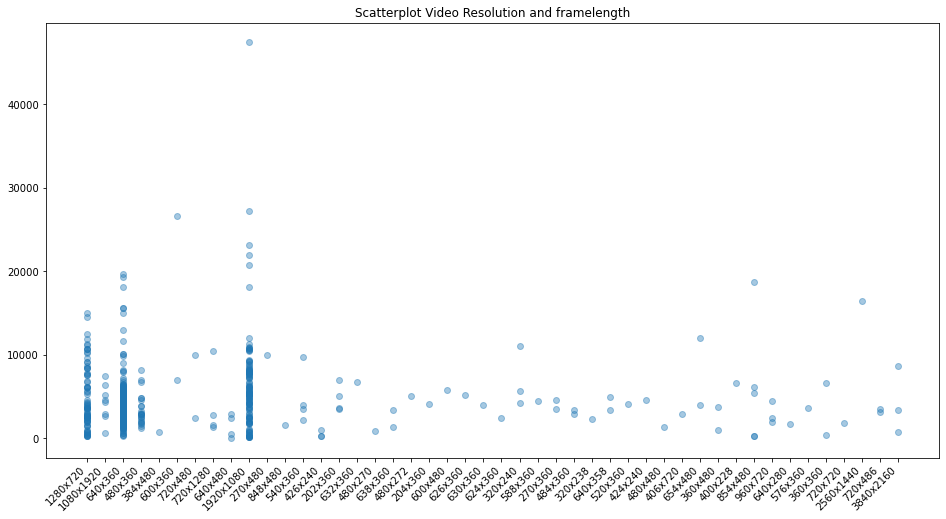

In [13]:
names = [
    (str(items[2]) + "x" + str(items[1])) for items in list(AW2_video_shapes.values())
]
fig, axes = plt.subplots(figsize=(16, 8))
axes.set_title("Scatterplot Video Resolution and framelength")
axes.scatter(names, AW2_all_sequenceslength, alpha=0.4)
plt.xticks(rotation=45, ha="right");

### Violinplot of sequence length per resolution

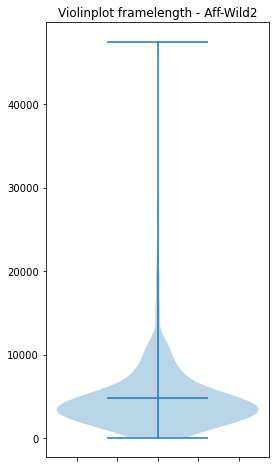

In [14]:
fig, axes = plt.subplots(figsize=(4, 8))
axes.set_title("Violinplot framelength - Aff-Wild2")
axes.violinplot(AW2_all_sequenceslength, showmeans=True)
axes.set_xticklabels([]);

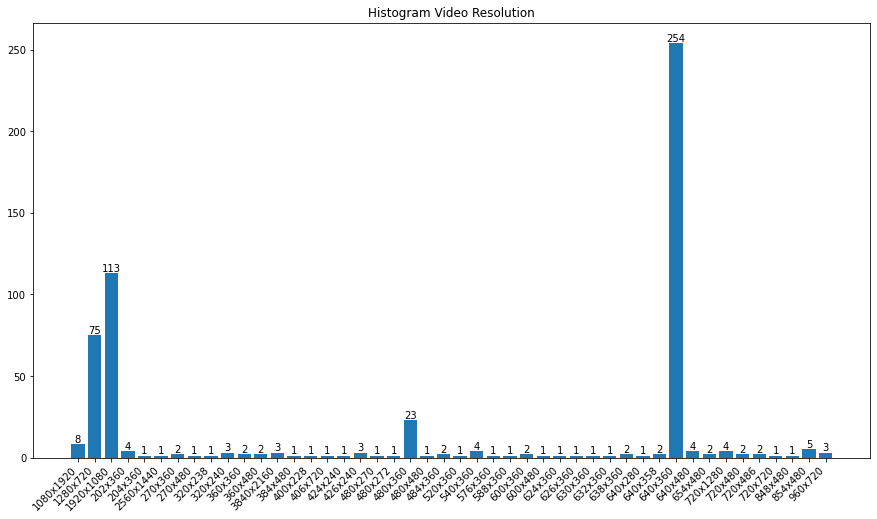

In [15]:
AW2_res_dist = {
    resolution: names.count(resolution) for resolution in sorted(set(names))
}

fig, axes = plt.subplots(figsize=(15, 8))
ax1 = axes.bar(AW2_res_dist.keys(), AW2_res_dist.values())
axes.set_title("Histogram Video Resolution")
plt.xticks(rotation=45, ha="right")
for rect in ax1:
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom",
    );

## Framerate of each video 

In [16]:
# Grab the framerate for each video in the Aff-wild2 dataset.
# Then convert it to avg framerate value in decimals.
AW2_framerates = {}
for video in AW2_videos_FN:
    metadata = skvideo.io.ffprobe(join(AW2_dir_allvideos, video))
    num, denom = (metadata.get("video").get("@avg_frame_rate")).split("/")
    AW2_framerates[video] = int(num) / int(denom)

In [17]:
AW2_framerates

{'1-30-1280x720.mp4': 30.0,
 '10-60-1280x720.mp4': 30.0,
 '100-29-1080x1920.mp4': 30.0,
 '101-30-1080x1920.mp4': 30.0,
 '102-30-640x360.mp4': 30.0,
 '102.avi': 25.0,
 '103-30-384x480.mp4': 30.0,
 '103.avi': 30.0,
 '104-17-720x480.mp4': 30.0,
 '105-30-1280x720.mp4': 30.0,
 '105.avi': 29.97002997002997,
 '106-30-720x1280.mp4': 30.0,
 '106.avi': 23.976023976023978,
 '107-30-640x480.mp4': 30.0,
 '107.avi': 29.97002997002997,
 '108-15-640x480.mp4': 30.0,
 '108.avi': 23.976023976023978,
 '109-30-1280x720.mp4': 30.0,
 '11-24-1920x1080.mp4': 30.0,
 '110-30-270x480.mp4': 30.0,
 '110.avi': 30.0,
 '111-25-1920x1080.mp4': 30.0,
 '111.avi': 29.97002997002997,
 '112-30-640x360.mp4': 30.0,
 '112.avi': 23.976023976023978,
 '113-60-1280x720.mp4': 30.0,
 '113.avi': 29.97002997002997,
 '114-30-1280x720.mp4': 30.0,
 '114.avi': 29.97002997002997,
 '115-30-1280x720.mp4': 30.0,
 '116-30-1280x720.mp4': 30.0,
 '116.avi': 30.0,
 '117-25-1920x1080.mp4': 30.0,
 '117.avi': 29.97002997002997,
 '118-30-640x480.mp4':

In [18]:
# Put all framerates in a list
AW2_all_framerates = [AW2_framerates.get(video) for video in AW2_videos_FN]

# Count the occurence of each framerate to get the distribution
AW2_framerates_dist = {
    framerate: AW2_all_framerates.count(framerate)
    for framerate in sorted(set(AW2_all_framerates))
}

## Some Summary statistics about framerates

In [19]:
print(f"The mean length of all framerates: {np.mean(AW2_all_framerates)} frames")
print(
    f"The median length of all framerates: {np.median(AW2_all_framerates)} frames"
)
print(f"The SD of length of all framerates: {np.std(AW2_all_framerates)} frames")

The mean length of all framerates: 27.83014004503135 frames
The median length of all framerates: 30.0 frames
The SD of length of all framerates: 3.76331550811549 frames


In [52]:
AW2_framerates_dist

{7.5: 1,
 7.666666666666667: 1,
 10.0: 1,
 13.498655753355806: 1,
 13.75: 1,
 14.60983606557377: 1,
 15.452: 1,
 15.916666666666666: 1,
 16.0: 1,
 16.500881360701758: 1,
 17.0: 1,
 18.227513227513228: 1,
 18.242368177613322: 1,
 18.625991458206222: 1,
 18.990912289913034: 1,
 19.4446538337662: 1,
 19.496083845143943: 1,
 20.08349677793497: 1,
 20.083507652568425: 1,
 20.08499381529154: 1,
 20.10213556174559: 1,
 20.130584192439862: 1,
 20.319103494027367: 1,
 20.327554899724305: 1,
 20.348271766041144: 1,
 20.382387847723045: 1,
 20.455607476635514: 1,
 20.476190476190474: 1,
 20.54380664652568: 1,
 20.573811931243682: 1,
 20.604395604395606: 1,
 20.805484147386462: 1,
 20.817088345085025: 1,
 20.829545454545453: 1,
 20.91076625238116: 1,
 20.930771188355017: 1,
 20.969075172614996: 1,
 21.068813947667618: 1,
 21.119500130174433: 1,
 21.123989534650935: 1,
 21.243750796640654: 1,
 21.32001647446458: 1,
 21.346329576606763: 1,
 21.353173938293736: 1,
 21.479713603818617: 1,
 21.58251305

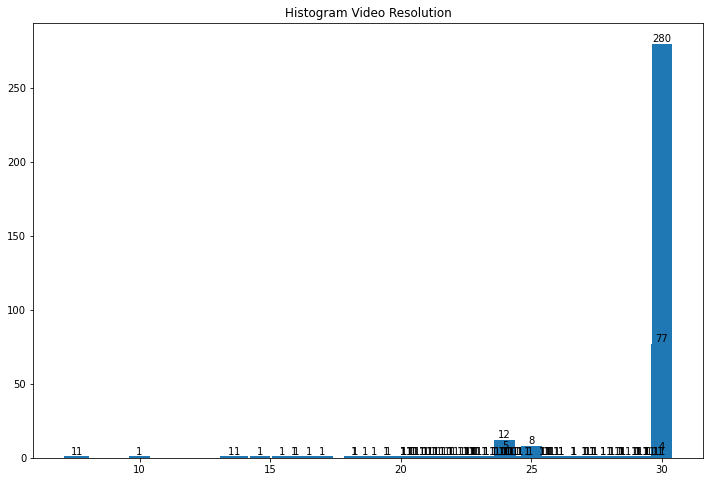

In [21]:
fig, axes = plt.subplots(figsize=(12, 8))
ax1 = axes.bar(AW2_framerates_dist.keys(), AW2_framerates_dist.values())
axes.set_title("Histogram Video framerate")
for rect in ax1:
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom",
    );

## Classes per video in training and validation set ##

In [54]:
# Load all txt files and create dictionary where each key is the filename and value is all the values (annotations) in the text file
AW2_train_classes = {}
for ann_file in AW2_train_FN:
    with open(join(AW2_dir_train_labels, ann_file), "r") as fp:
        AW2_train_classes[ann_file] = list(map(int, (fp.read().splitlines()[1:])))

AW2_val_classes = {}
for ann_file in AW2_val_FN:
    with open(join(AW2_dir_val_labels, ann_file), "r") as fp:
        AW2_val_classes[ann_file] = list(map(int, (fp.read().splitlines()[1:])))

In [67]:
# Save json file with all annotations_files and values
with open("data/AW2_train_classes.json", "w") as fp:
    json.dump(AW2_train_classes, fp)

# Save json file with all annotations_files and values
with open("data/AW2_val_classes.json", "w") as fp:
    json.dump(AW2_val_classes, fp)

In [68]:
# Checking if the lentgh of each text annotated file is the same as the amount of frames in a video.
for ann_file in AW2_train_FN:
    name, ext = splitext(ann_file)
    if "_left" in name:
        name = name.replace("_left", "")
    elif "_right" in name:
        name = name.replace("_right", "")
    x = AW2_seqlength_without_extension.get(name)[0]
    y = len(AW2_train_classes.get(ann_file))
    print([ann_file], f"has {y-x} more annotation than frames")

['1-30-1280x720.txt'] has 1 more annotation than frames
['10-60-1280x720.txt'] has 1 more annotation than frames
['10-60-1280x720_right.txt'] has 1 more annotation than frames
['100-29-1080x1920.txt'] has 1 more annotation than frames
['101-30-1080x1920.txt'] has 1 more annotation than frames
['102-30-640x360.txt'] has 1 more annotation than frames
['102.txt'] has 1 more annotation than frames
['103-30-384x480.txt'] has 1 more annotation than frames
['103.txt'] has 1 more annotation than frames
['104-17-720x480.txt'] has 1 more annotation than frames
['105-30-1280x720.txt'] has 1 more annotation than frames
['105.txt'] has 1 more annotation than frames
['106-30-720x1280.txt'] has 1 more annotation than frames
['106.txt'] has 2 more annotation than frames
['107-30-640x480.txt'] has 0 more annotation than frames
['107.txt'] has 1 more annotation than frames
['108-15-640x480.txt'] has 1 more annotation than frames
['108.txt'] has 2 more annotation than frames
['109-30-1280x720.txt'] has 1

In [69]:
# Checking if the lentgh of each text annotated file is the same as the amount of frames in a video.
for ann_file in AW2_val_FN:
    name, ext = splitext(ann_file)
    if "_left" in name:
        name = name.replace("_left", "")
    elif "_right" in name:
        name = name.replace("_right", "")
    x = AW2_seqlength_without_extension.get(name)[0]
    y = len(AW2_val_classes.get(ann_file))
    print([ann_file], f" has {y-x} more annotation than frames")

['117.txt']  has 1 more annotation than frames
['118-30-640x480.txt']  has 0 more annotation than frames
['118.txt']  has 1 more annotation than frames
['119-30-848x480.txt']  has 1 more annotation than frames
['119.txt']  has 2 more annotation than frames
['120-30-1280x720.txt']  has 0 more annotation than frames
['120.txt']  has 1 more annotation than frames
['121-24-1920x1080.txt']  has 1 more annotation than frames
['121.txt']  has 1 more annotation than frames
['122-60-1920x1080-2.txt']  has 1 more annotation than frames
['122-60-1920x1080-3.txt']  has 1 more annotation than frames
['122-60-1920x1080-4.txt']  has 1 more annotation than frames
['122.txt']  has 1 more annotation than frames
['123-25-1920x1080.txt']  has 1 more annotation than frames
['123.txt']  has 1 more annotation than frames
['124-30-720x1280.txt']  has 1 more annotation than frames
['125-25-1280x720.txt']  has 1 more annotation than frames
['125.txt']  has 1 more annotation than frames
['126.txt']  has 1 more a


It seems that each annotated file has about 0 to 2 more annotations than the amount of frames in a video
***

**Response from researcher Dimitrios**

Hello Ion,

If the difference is 1-2 annotations you can safely disregard these.

At first I extracted the fps per video and then used ffmpeg command (a code snippet can be seen below):

fps_check = subprocess.check_output('ffprobe '+video_name+' 2>&1 | grep fps',shell=True)
fps_check = str(fps_check)
fps = float(fps_check.split(' fps')[0].split(',')[-1][1:])

subprocess.call('ffmpeg -loglevel panic -i '+video_name+' -vf fps='+ str(fps)+' '+location_to_extract+'/%05d.jpg',shell=True)

Kind Regards,
Dimitris

### Distribution of each class per video and set ###

In [95]:
names_class = [
    "neutral",
    "anger",
    "disgust",
    "fear",
    "happiness",
    "sadness",
    "surprise",
]

# Facial Expression Class distribution per video of training set
AW2_train_classdist = {}
for ann_file in AW2_train_FN:
    values = AW2_train_classes.get(ann_file)
    AW2_train_classdist[ann_file] = {
        name: np.sum(np.array(values) == i) for name, i in zip(names_class, range(0, 7))
    }

# Facial Expression Class distribution per video of validation set
AW2_val_classdist = {}
for ann_file in AW2_val_FN:
    values = AW2_val_classes.get(ann_file)
    AW2_val_classdist[ann_file] = {
        name: np.sum(np.array(values) == i) for name, i in zip(names_class, range(0, 7))
    }

In [98]:
AW2_train_classdist

{'1-30-1280x720.txt': {'neutral': 7775,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 2581,
  'sadness': 0,
  'surprise': 0},
 '10-60-1280x720.txt': {'neutral': 717,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 1222,
  'sadness': 0,
  'surprise': 202},
 '10-60-1280x720_right.txt': {'neutral': 45,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 481,
  'sadness': 0,
  'surprise': 0},
 '100-29-1080x1920.txt': {'neutral': 660,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 1917,
  'sadness': 0,
  'surprise': 18},
 '101-30-1080x1920.txt': {'neutral': 298,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 3505,
  'sadness': 0,
  'surprise': 0},
 '102-30-640x360.txt': {'neutral': 1221,
  'anger': 1726,
  'disgust': 0,
  'fear': 0,
  'happiness': 0,
  'sadness': 0,
  'surprise': 0},
 '102.txt': {'neutral': 985,
  'anger': 0,
  'disgust': 0,
  'fear': 891,
  'happiness': 0,
  'sadness': 1811,
  'surprise': 0},
 '103-30-384x480.txt': {'neutra

In [97]:
AW2_train_highlevel_dist

{'neutral': 0,
 'anger': 0,
 'disgust': 0,
 'fear': 0,
 'happiness': 0,
 'sadness': 0,
 'surprise': 0}

### Training set: Facial Expression Class distribution

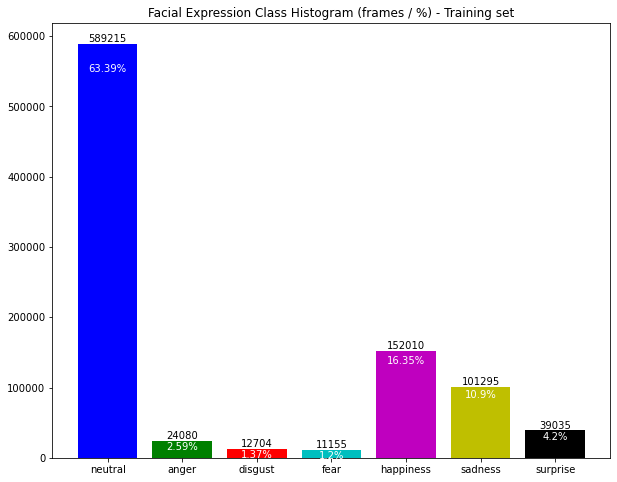

In [99]:
AW2_train_highlevel_dist = {i: 0 for i in names_class}
for ann_file in AW2_train_FN:
    values = AW2_train_classdist.get(ann_file)
    for name in AW2_train_highlevel_dist.keys():
        AW2_train_highlevel_dist[name] += values.get(name)

AW2_distplotter(
    AW2_train_highlevel_dist,
    "Facial Expression Class Histogram (frames / %) - Training set"
)

### Validation set: Facial Expression Class distribution

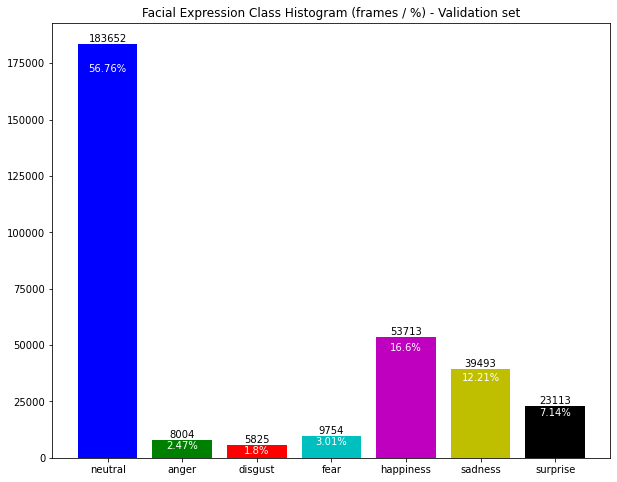

In [101]:
AW2_val_highlevel_dist = {i: 0 for i in names_class}
for ann_file in AW2_val_FN:
    values = AW2_val_classdist.get(ann_file)
    for name in AW2_val_highlevel_dist.keys():
        AW2_val_highlevel_dist[name] += values.get(name)

AW2_distplotter(
    AW2_val_highlevel_dist,
    "Facial Expression Class Histogram (frames / %) - Validation set",
)